## ANN 介绍

In [2]:
# 环境检查 设置
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow as tf 
assert tf.__version__ >= "2.0"

import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

### 感知机

In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [4]:
y_pred

array([1])

In [5]:
import pandas as pd
df = pd.DataFrame(iris.data)
df.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


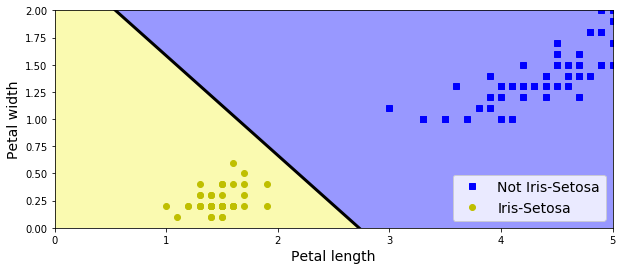

In [6]:
# 绘制
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 500).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")
# X.shape (150, 2) X[y==0] 获取y==0 的行

# 绘制决策边界
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(["#9898ff", "#fafab0"])

plt.contourf(x0, x1, zz, cmap=custom_cmap) # 等高线绘制方法
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

### 激活函数

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

# 计算导数
def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

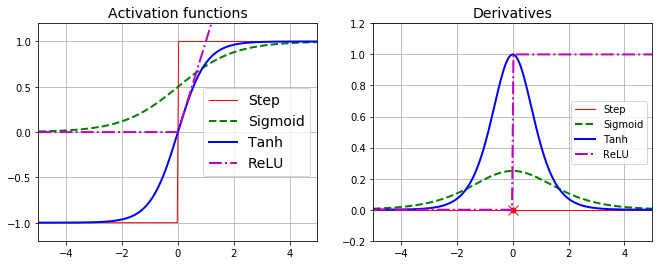

In [8]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=10) 
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### XOR
感知机的一些限制，可以通过堆叠多层感知机来解决。
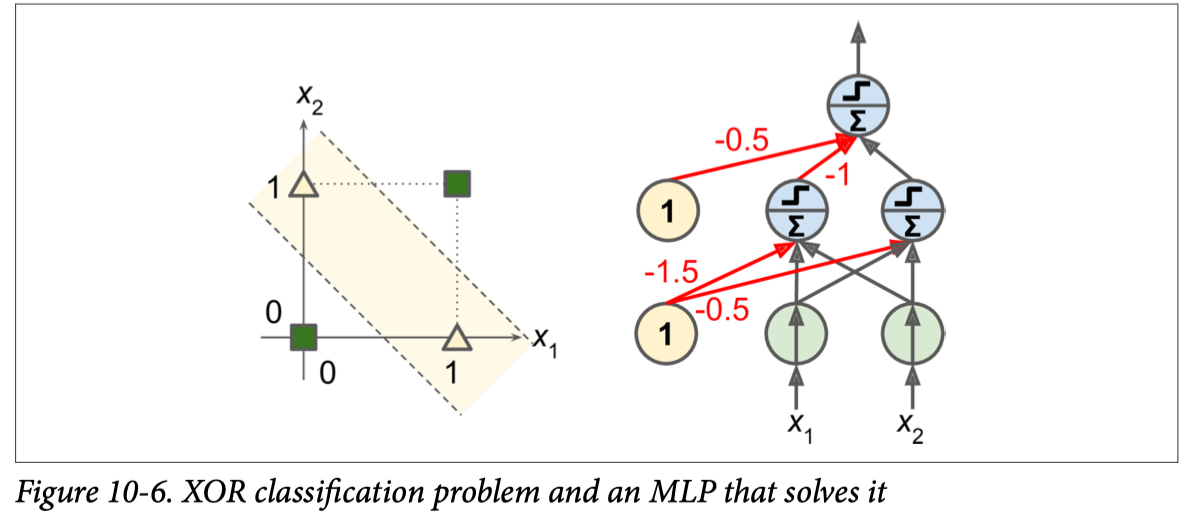

In [9]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

# 最终异或的结果计算
def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

### 创建一个图片分类器

In [10]:
import tensorflow as tf
from tensorflow import keras

In [11]:
tf.__version__

'2.0.0'

In [12]:
keras.__version__

'2.2.4-tf'

In [13]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

这个训练集中包含 60000 张黑白图片，28 X 28 像素

In [14]:
print(X_train_full.shape, X_train_full.dtype)

(60000, 28, 28) uint8


创建验证集，并且将颜色值缩放到 0-1 之间

In [15]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

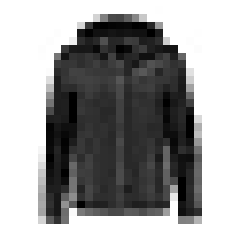

In [16]:
# 绘制一张图
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [17]:
# labe 都是数字 下面是对应的分类名称
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

class_names[y_train[0]]

'Coat'

#### 绘制一些例子图片

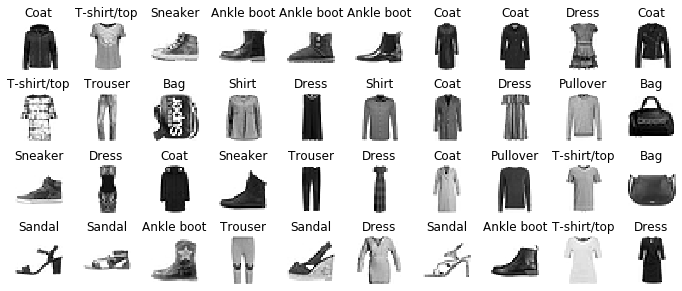

In [18]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(class_names[y_train[index]], fontsize=12)

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
plt.show()

#### 创建 Sequential Model

In [19]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [20]:
# 保证每次结果运行一致
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
model.layers

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


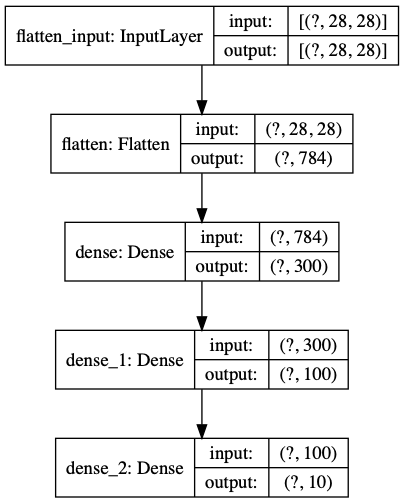

In [23]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [24]:
# test code 上面图上 冒号左边的是每一层的名字
hidden1 = model.layers[1]
print(hidden1.name, model.get_layer(hidden1.name) is hidden1)

dense True


In [25]:
weights, biases = hidden1.get_weights()
weights

array([[-0.04640817,  0.01980416,  0.07340917, ..., -0.01419546,
        -0.05201929,  0.06962535],
       [-0.03074887, -0.02396787, -0.0297224 , ..., -0.00222993,
         0.05328803, -0.00730975],
       [ 0.01776908,  0.04917809, -0.01356958, ...,  0.00163247,
        -0.00357375, -0.00043227],
       ...,
       [-0.05702399, -0.04900238, -0.02175619, ..., -0.06771003,
         0.02330816,  0.06945625],
       [ 0.06028481,  0.04600426,  0.04877156, ..., -0.07403199,
         0.02704618, -0.05212691],
       [-0.03604995,  0.06175737, -0.01283891, ...,  0.03142713,
         0.05345166, -0.06857612]], dtype=float32)

In [26]:
weights.shape
# 表示在 hidden1 层 有这些个参数 因为目前是全连接网络，所以对于每一个神经元都有784个参数

(784, 300)

In [27]:
biases.shape

(300,)

这里可以理解成每一个神经元都是 y=w*x+b 函数。

In [28]:
# 编译model
model.compile(loss="sparse_categorical_crossentropy", # keras.losses.sparse_categorical_crossentropy
             optimizer="sgd", # keras.optimizers.SGD()
             metrics=["accuracy"]) # keras.metrics.sparse_categorical_accuracy

In [ ]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
